# EDA для предсказания рейтинга отелей

In [61]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
import nltk
import warnings
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.distance import geodesic
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from afinn import Afinn

In [2]:
warnings.filterwarnings('ignore')
nltk.downloader.download('vader_lexicon')
pio.renderers.default = 'png'

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
hotels_train = pd.read_csv('data/hotels.csv')
hotels_test = pd.read_csv('data/hotels_test.csv')
sample_submission = pd.read_csv('data/submission.csv')

### Давайте посотрим на данные

In [4]:

train_code = """
<div style="font-size: 20px; font-weight: bold; transform: skew(-15deg);">
Выборка для обучения
</div>
"""
test_code = """
<div style="font-size: 20px; font-weight: bold; transform: skew(-15deg);">
Выборка для предсказания
</div>
"""
submission_code = """
<div style="font-size: 20px; font-weight: bold; transform: skew(-15deg);">
Сабмишн
</div>
"""
display(HTML(train_code))
display(hotels_train.head(3)),
hotels_train.info(),
display(HTML(test_code)),
display(hotels_test.head(3)),
hotels_test.info(),
display(HTML(submission_code)),
display(sample_submission.head(3)),
sample_submission.info()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [5]:
hotels_train['sample'] = 1
hotels_test['sample'] = 0
hotels_test['reviewer_score'] = 0

# Объединяем датафреймы hotels_test и hotels_train
hotels = pd.concat([hotels_test, hotels_train], ignore_index=True)

In [6]:
# посмотрим что получлось
hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,0.0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,0,0.0


___

### Описание столбцов

* hotel_address — адрес отеля;
* review_date — дата, когда рецензент разместил соответствующий отзыв;
* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* hotel_name — название отеля;
* reviewer_nationality — страна рецензента;
* negative_review — отрицательный отзыв, который рецензент дал отелю;
* review_total_negative_word_counts — общее количество слов в отрицательном отзыве;
* positive_review — положительный отзыв, который рецензент дал отелю;
* review_total_positive_word_counts — общее количество слов в положительном отзыве.
* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
* total_number_of_reviews — общее количество действительных отзывов об отеле;
* tags — теги, которые рецензент дал отелю;
* days_since_review — количество дней между датой проверки и датой создания датасета;
* additional_number_of_scoring — количество оценок без отзыва;
* lat — географическая широта отеля;
* lng — географическая долгота отеля.

### Мысли о некоторых признаках и дальнейшей работе с ними.

#### hotel_address
Каждый адрес состоит из примерно следующего шаблона - "название улицы, номер дома, уточненяющие детали(номер квартиры или район города), почтовый индекс города, название города, страна".

Что мы можем получить из этого признака:

* новый признак страна отеля
* город отеля
* столицу страны
* координаты города отеля и координаты столицы с помощью библиотек
* посчитать расстояние между этими координатами и получить новый признак расстояние от отеля до столицы, отсюда же можно выделить ещё один признак - является ли город отеля столицей (например, если расстояние до центра столицы не более 50 км)

#### review_date
Дата с точностью до дня. Можно попробовать создать 4 признака сезонности(с помощью OneHotEncoder): зима, весна, лето, осень. Возможно, в какие-то времена года рецензенты ставят более высокие оценки, чем в другие.

#### reviewer_nationality
Из какой страны рецензент прибыл в отель. Можем закодировать топ наиболее встречающихся национальностей, а остальные пометить как 'other'. Ещё мы можем создать бинарный признак, который будет давать информацию о том, является ли рецензент жителем страны, в отеле которой поселился.

#### negative_review & positive_review
Отзывы можно проанализировать с помощью сторонней библиотеки на соотношение положительных, отрицательных и нейтральных слов.

#### review_total_negative_word_counts & review_total_positive_word_counts
Чем больше слов в одной из категорий отзывов - тем выше шанс, что человек склоняется к тому варианту, где он больше написал. Если много слов в отрицательном отзыве и мало в положительным - почти очевидно, что будет поставлена низкая оценка. Можно попробовать создать признак, показывающий соотношение позитивных слов к негативным.

#### total_number_of_reviews_reviewer_has_given
Признак, оценивающий надёжность ревьювера. Если он дал много отзывов в прошлом, значит с большей долей вероятности можно считать, что отзыв был объективен. Можно попробовать создать признак, показывающий эту самую надёжность в бинарном представлении (0 - меньше 5 отзывов, 1 - больше 5 отзывов).

#### total_number_of_reviews
Признак надёжности отеля. Если отзывов много, то средний рейтинг можно считать объективным. Если отзывов мало - нельзя, т.к. такой отзыв мог оставить, например, конкурент из отельного бизнеса, чтобы помешать развитию.

#### days_since_review
Вероятно, данный признак имеет небольшой вес и его не стоит удалять, хотя и кажется, что пользы не несёт. Например, если прошло уже достаточно много дней с момента последнего отзыва, значит, что этот отзыв был, скорее всего, негативным, и отель больше не привлекает новых посетителей. Если нет новых посетителей - отель либо закрывается, либо уменьшаются затраты на его содержание, что напрямую влияет на итоговый рейтинг.

#### lat & lng
Широту и долготу будем использовать для расчета расстояния между городом отеля и столицей страны.

___

### Проведем предварительный анализ данных

In [7]:
# посмотрим данные и признаки
display(hotels.info()),
print('в данных', hotels.isnull().sum().sort_values(ascending=False)[0], 'пропусков'),
print('\n'),
display(hotels.nunique()),
print('и', hotels[hotels.duplicated()].shape[0], 'дубликатов'),
print('\n'),
display(hotels.describe()),
print('\n')
display(hotels.describe(include='object'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

None

в данных 3268 пропусков




hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1472
lng                                             1472
sample                                             2
reviewer_score                                    38
dtype: int64

и 336 дубликатов




,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,sample,reviewer_score
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,512470.000000,512470.000000,515738.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,49.442439,2.823803,0.749999,6.297672
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,3.466325,4.579425,0.433014,3.902295
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,41.328376,-0.369758,0.000000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,48.214662,-0.143372,0.250000,0.625000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,51.499981,0.010607,1.000000,7.900000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,51.516288,4.834443,1.000000,9.600000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,52.400181,16.429233,1.000000,10.000000


,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review
count,515738,515738,515738,515738,515738,515738,515738,515738
unique,1493,731,1492,227,330011,412601,55242,731
top,163 Marsh Wall Docklands Tower Hamlets London ...,8/2/2017,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days
freq,4789,2585,4789,245246,127890,35946,5101,2585


___

### Добавим признак страны отеля и информацию о населении в стране каждого отеля

Посмотрим на пример строк из признака hotel_address, чтобы выделить оттуда важную информацию и увидеть структуру строк.

In [8]:
for i in range(0, 10, 2):
    display(hotels['hotel_address'].iloc[i])

'Via Senigallia 6 20161 Milan Italy'

'Mallorca 251 Eixample 08008 Barcelona Spain'

'Singel 303 309 Amsterdam City Center 1012 WJ Amsterdam Netherlands'

'Empire Way Wembley Brent London HA9 8DS United Kingdom'

'35 Rue Caumartin 9th arr 75009 Paris France'

Возьмем таблицу с Википедии о названии и населении(в миллионах) всех стран.

In [9]:
countries_info = pd.read_html('https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population')[0]
total_population = countries_info['Population'].iloc[0]
countries_info['% of the world'] = (countries_info['Population'] / 1e6).round(2)
countries_info = countries_info.sort_index(axis=1).drop(
    columns=['Date', 'Notes', 'Source (official or from the United Nations)', 'Population','Unnamed: 0'],
    index=0).rename(
    columns={'% of the world': 'population',
             'Country / Dependency': 'country',
             'Location': 'country'}).sort_index(axis=1)
countries_info.head()

,% of world,country,population
1,17.3%,China,1409.67
2,17.2%,India,1404.91
3,4.2%,United States,340.11
4,3.5%,Indonesia,282.48
5,3.0%,Pakistan,241.50


Создадим признак country, в котором будет информация о стране, в которой располагается отель. Присоединим к нему столбец с населением.

In [10]:
def get_country(address:str) -> str:

    for country in countries_info['country'].to_list():
        if country in ' '.join(address.split()[-2:]):
            return country

hotels['country'] = hotels['hotel_address'].apply(get_country)
hotels = hotels.join(countries_info.set_index('country'), on='country')
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,country,% of world,population
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0,Italy,0.7%,58.97
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0,Netherlands,0.2%,18.04
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,...,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0,Spain,0.6%,48.95


In [11]:
# убедимся, что ничего не пропустили
hotels['country'].isnull().sum()

0

___

### Анализ каждого числового признака из оригинального датасета

Выделим все числовые признаки в отдельный датафрейм, чтобы было удобнее их анализировать. lat и lng не будем включать в этот список, т.к. мы всё равно удалим координаты.

In [12]:
num_features = hotels[[col for col in hotels.columns if hotels[col].dtype != 'object']].drop(columns=['lat', 'lng'])
num_features.head()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,sample,reviewer_score,population
0,904,8.1,52,16670,62,1,0,0.0,58.97
1,612,8.6,10,5018,0,7,0,0.0,18.04
2,46,8.3,3,351,5,15,0,0.0,48.95
3,241,9.1,0,1543,27,9,0,0.0,58.97
4,834,9.1,0,4687,7,2,0,0.0,18.04


#### additional_number_of_scoring

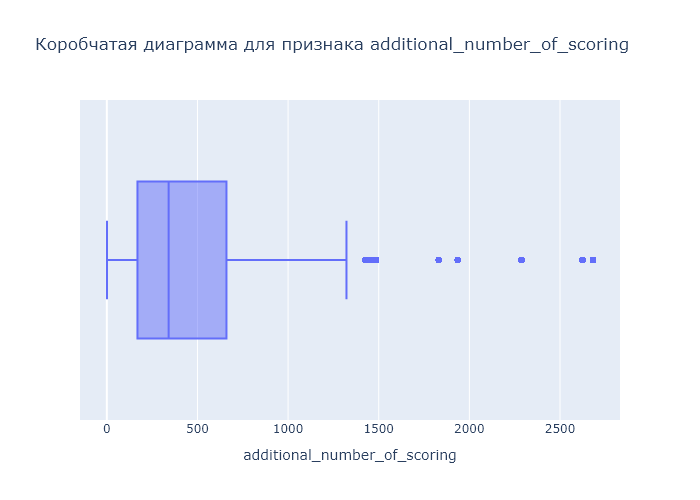

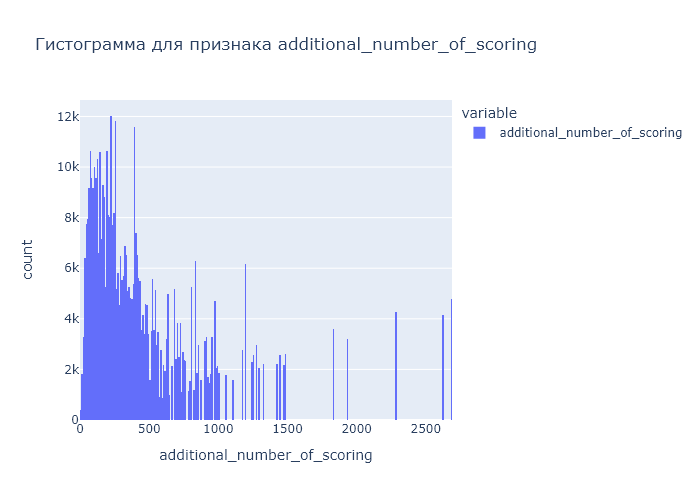

In [13]:
additional_scoring_box = px.box(
    x=num_features['additional_number_of_scoring'],
    height=500,
    width=700,
    title='Коробчатая диаграмма для признака additional_number_of_scoring',
    labels={'x': 'additional_number_of_scoring'}
)
additional_scoring_hist = px.histogram(
    num_features['additional_number_of_scoring'],
    height=500,
    width=700,
    title='Гистограмма для признака additional_number_of_scoring',
    labels={'value': 'additional_number_of_scoring'}
)
additional_scoring_box.show()
additional_scoring_hist.show()

По коробчатой диаграмме можно подумать, что тут есть аномальные значения(выбросы), которые необходимо удалить, но гистограмма говорит об обратном - значения признака выше 1500 встречаются не так уж редко, чтобы называть их выбросами.

#### average_score

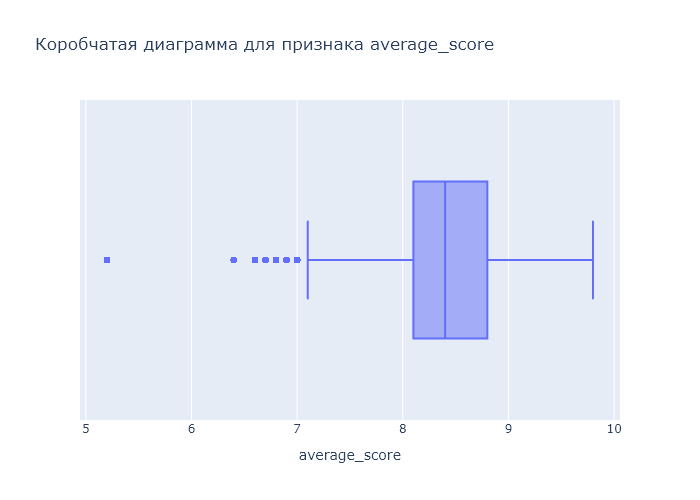

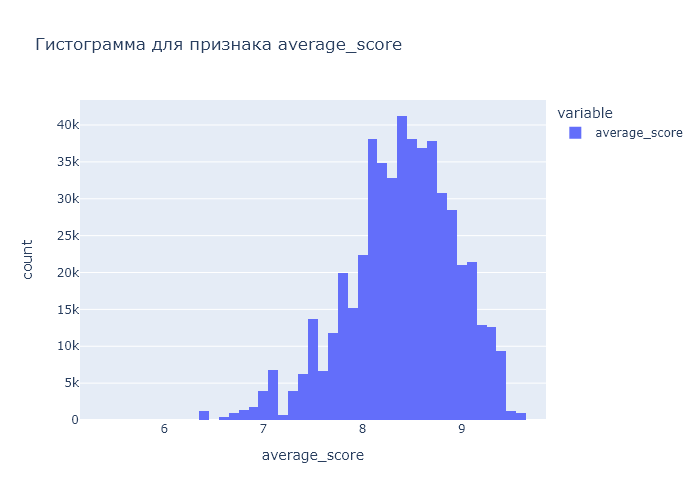

In [14]:
average_score_box = px.box(
    x=num_features['average_score'],
    height=500,
    width=700,
    title='Коробчатая диаграмма для признака average_score',
    labels={'x': 'average_score'}
)
average_score_hist = px.histogram(
    num_features['average_score'],
    height=500,
    width=700,
    title='Гистограмма для признака average_score',
    labels={'value': 'average_score'}
)
average_score_box.show()
average_score_hist.show()

#### review_total_negative_word_counts

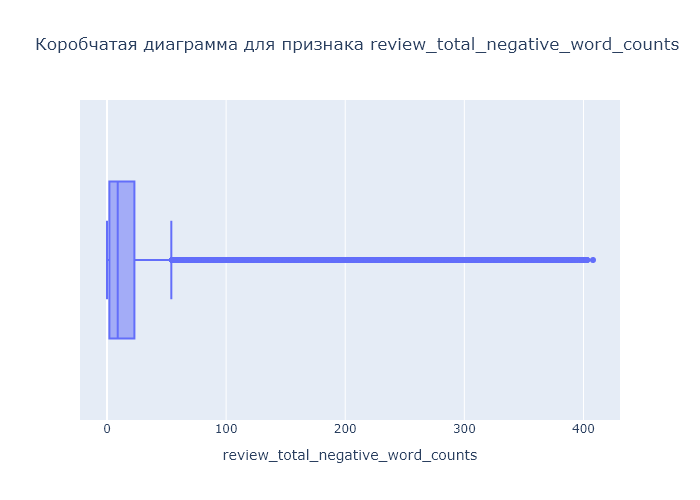

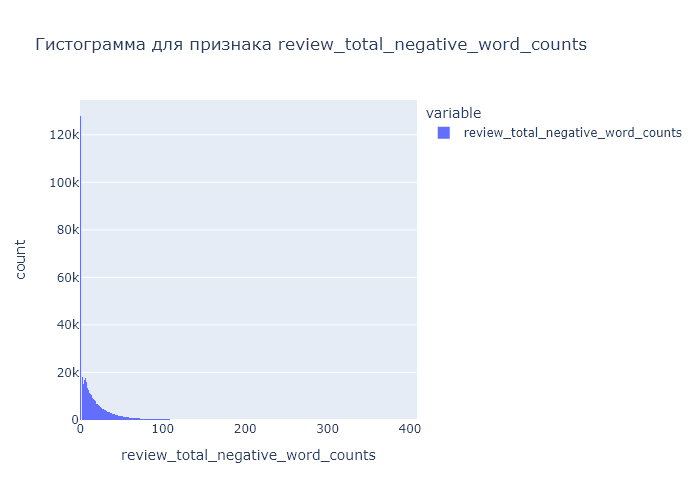

In [15]:
total_negative_box = px.box(
    x=num_features['review_total_negative_word_counts'],
    height=500,
    width=700,
    title='Коробчатая диаграмма для признака review_total_negative_word_counts',
    labels={'x': 'review_total_negative_word_counts'}
)
total_negative_hist = px.histogram(
    num_features['review_total_negative_word_counts'],
    height=500,
    width=700,
    title='Гистограмма для признака review_total_negative_word_counts',
    labels={'value': 'review_total_negative_word_counts'}
)
total_negative_box.show()
total_negative_hist.show()

In [16]:
# Посмотрим, сколько записей имеют более 100 негативных слов в отзыве
num_features[num_features['review_total_negative_word_counts'] > 100].shape[0]

11637

Данный признак имеет логнормальное распределение. Чаще всего количество негативных слов = 0. Думаю, этот признак довольно важен, т.к. может напрямую влиять на целевую переменную рейтинга. Больше негативных слов -> хуже рейтинг. И наоборот. Оставим в таком виде

#### total_number_of_reviews

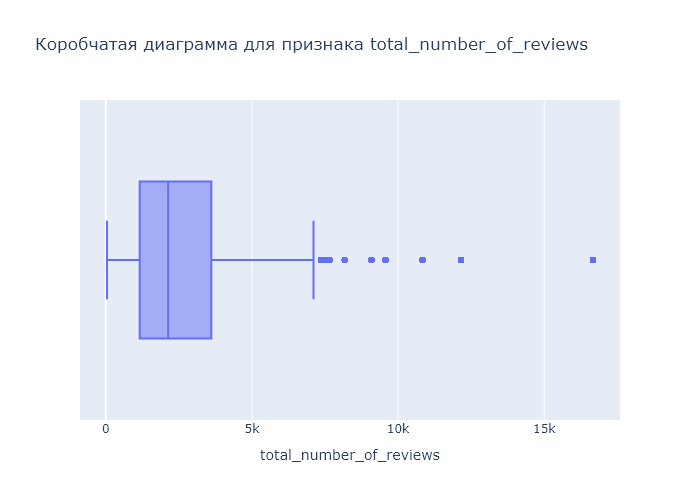

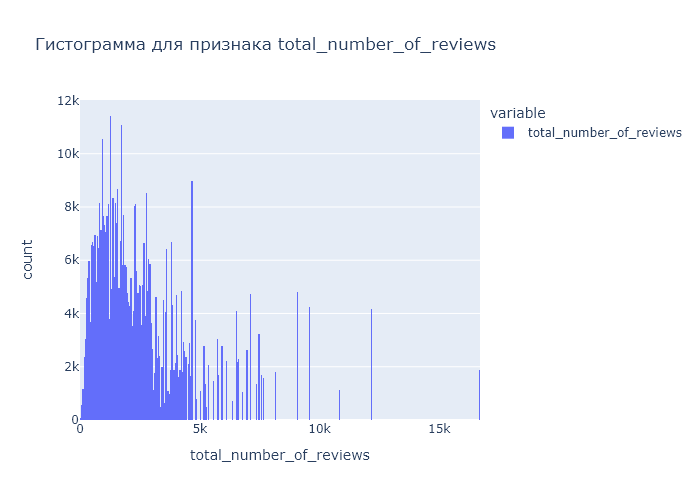

In [17]:
total_reviews_box = px.box(
    x=num_features['total_number_of_reviews'],
    height=500,
    width=700,
    title='Коробчатая диаграмма для признака total_number_of_reviews',
    labels={'x': 'total_number_of_reviews'}
)
total_reviews_hist = px.histogram(
    num_features['total_number_of_reviews'],
    height=500,
    width=700,
    title='Гистограмма для признака total_number_of_reviews',
    labels={'value': 'total_number_of_reviews'}
)
total_reviews_box.show()
total_reviews_hist.show()

total_number_of_reviews также похож на признак с логнормальным распределением. У большинства отелей количество отзывов не превышает 5000, но всегда есть наиболее популярные и те, которые существуют довольно давно, поэтому выше 15000 отзывов - вполне логичное значение для подобных отелей. Оставляем признак как есть.

#### review_total_positive_word_counts

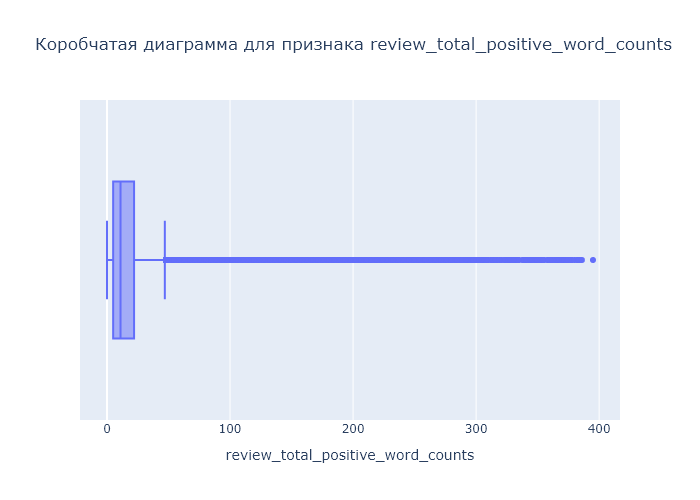

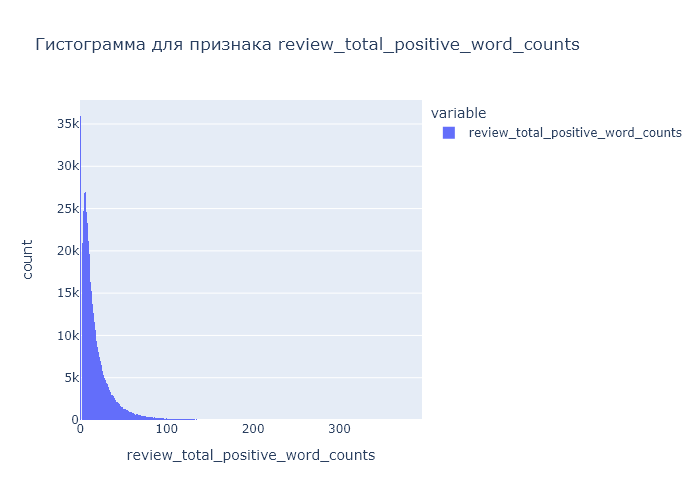

In [18]:
total_positive_box = px.box(
    x=num_features['review_total_positive_word_counts'],
    height=500,
    width=700,
    title='Коробчатая диаграмма для признака review_total_positive_word_counts',
    labels={'x': 'review_total_positive_word_counts'}
)
total_positive_hist = px.histogram(
    num_features['review_total_positive_word_counts'],
    height=500,
    width=700,
    title='Гистограмма для признака review_total_positive_word_counts',
    labels={'value': 'review_total_positive_word_counts'}
)
total_positive_box.show()
total_positive_hist.show()

Данный признак аналогичен признаку review_total_negative_word_counts по смыслу, но отображает количество позитивных слов в отзыве.

#### total_number_of_reviews_reviewer_has_given

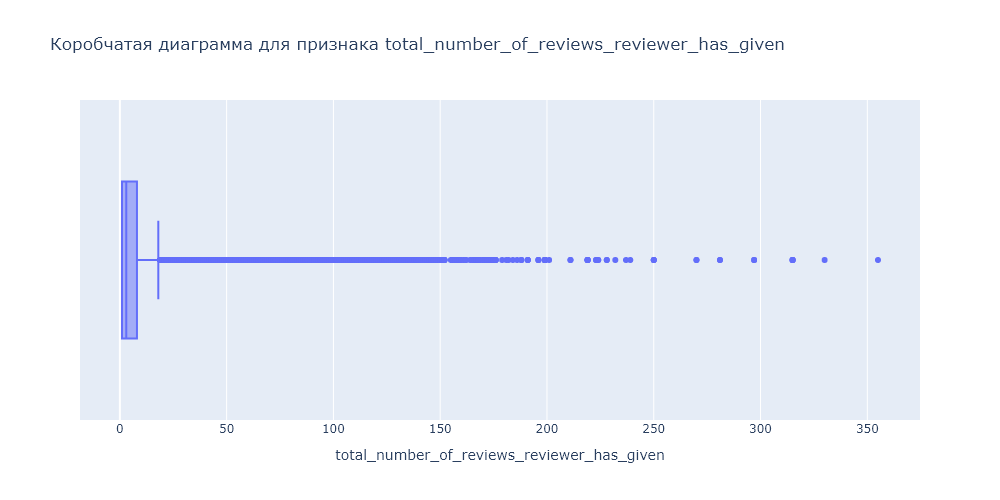

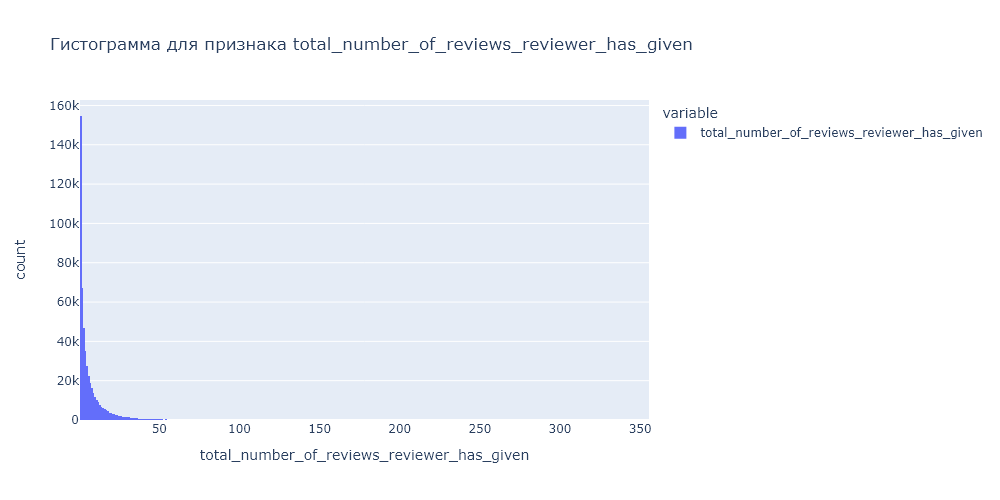

In [19]:
total_given_box = px.box(
    x=num_features['total_number_of_reviews_reviewer_has_given'],
    height=500,
    width=1000,
    title='Коробчатая диаграмма для признака total_number_of_reviews_reviewer_has_given',
    labels={'x': 'total_number_of_reviews_reviewer_has_given'}
)
total_given_hist = px.histogram(
    num_features['total_number_of_reviews_reviewer_has_given'],
    height=500,
    width=1000,
    title='Гистограмма для признака total_number_of_reviews_reviewer_has_given',
    labels={'value': 'total_number_of_reviews_reviewer_has_given'}
)
total_given_box.show()
total_given_hist.show()

Признак можно интерпретировать как "надёжность ревьювера". Чем больше отзывов оставил ревьювер - тем выше шанс, что его отзывы будут объективны, т.к. человек довольно ответственно подходит к этому занятию - оставлять отзыв к чему-либо.

#### reviewer_score (целевой признак)

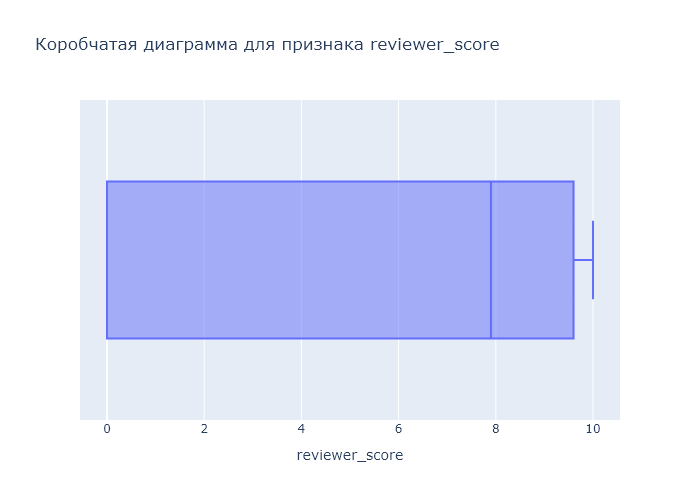

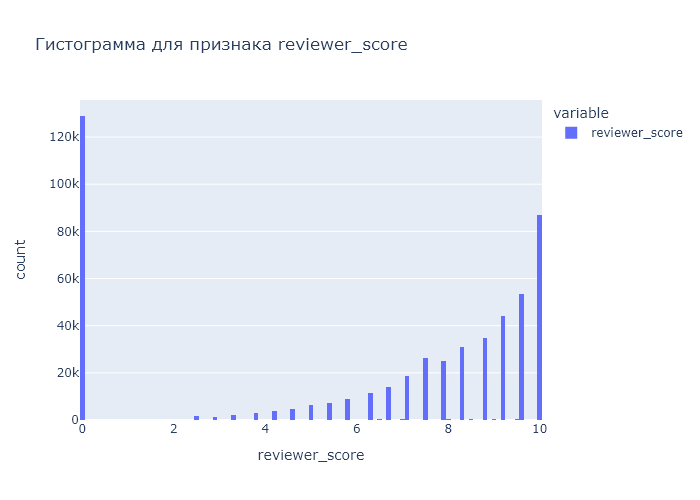

In [20]:
target_box = px.box(
    x=num_features['reviewer_score'],
    height=500,
    width=700,
    title='Коробчатая диаграмма для признака reviewer_score',
    labels={'x': 'reviewer_score'}
)
target_hist = px.histogram(
    num_features['reviewer_score'],
    height=500,
    width=700,
    title='Гистограмма для признака reviewer_score',
    labels={'value': 'reviewer_score'}
)
target_box.show()
target_hist.show()

Нули - заполненные нами вручную значения для предсказания, поэтому их не учитываем. Отрицательных значений не наблюдается, выше 10 - тоже нет. Можно сказать, что выбросов и аномальных значений нет в данном признаке. Однако это далеко не означает то, что все оценки проставленны объективно и справедливо.

___

### Заполняем пропущенные значения координат с помощью `geopy`

Посмотрим, в каких странах есть пропущенные значения.

In [21]:
countries_with_null = hotels[hotels['lat'].isna() | hotels['lng'].isna()]['country'].value_counts()
countries_with_null

country
Austria    2679
France      382
Spain       207
Name: count, dtype: int64

Можно заметить, что больше всего пропущенных значений находится в Австрии, а также есть во Франции и Испании.

Посмотрим на структуру адресов в этих странах, чтобы было проще заполнять пустые значения.

In [22]:
for country in countries_with_null.index:
    display(hotels[(hotels['lat'].isna() | hotels['lng'].isna()) 
                   & (hotels['country'] == country)].iloc[0].loc['hotel_address'])

'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria'

'23 Rue Damr mont 18th arr 75018 Paris France'

'Bail n 4 6 Eixample 08010 Barcelona Spain'

Видно, что последние 3 значения в строке представляют собой структуру [postal code + city + country]. Можем воспользоваться этой особенностью и заполнить пропущенные координаты с помощью библиотеки `geopy`.

Создадим отдельный датафрейм, который будет содержать в себе адрес, широту и долготу. Пропущенные значения заменим на строку, чтобы можно было заполнить эти значения с помощью метода apply, т.к. этот метод не работает с пропущенными (NaN/None) значениями.

In [23]:
address_coords = hotels[['hotel_address', 'lat', 'lng']].copy()
address_coords.fillna('unknown', inplace=True)
address_coords.head()

,hotel_address,lat,lng
0,Via Senigallia 6 20161 Milan Italy,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,41.393192,2.16152
3,Piazza Della Repubblica 17 Central Station 201...,45.479888,9.196298
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,52.370545,4.888644


Отобразим, как выглядят на данном этапе наши пропущенные значения, а потом сравним их после преобразования.

In [24]:
null_indexes = address_coords[address_coords['lat'] == 'unknown'].index
address_coords.iloc[null_indexes]

,hotel_address,lat,lng
35,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,unknown,unknown
293,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,unknown,unknown
476,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...,unknown,unknown
526,23 Rue Damr mont 18th arr 75018 Paris France,unknown,unknown
569,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...,unknown,unknown
...,...,...,...
515027,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,unknown,unknown
515400,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,unknown,unknown
515439,4 rue de la P pini re 8th arr 75008 Paris France,unknown,unknown
515637,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,unknown,unknown


Посмотрим на количество уникальных адресов.

In [25]:
address_coords.iloc[null_indexes]['hotel_address'].nunique()

17

Количество уникальных пропущенных адресов невелико, поэтому будем использовать запрос к OpenStreetMap с помощью библиотеки `geopy`.

In [31]:
# Создадим экземпляр класса Nominatim библиотеки geopy
geolocator = Nominatim(user_agent='project_3')
# Создадим экземпляр класса RateLimiter, чтобы ограничить задержку между запросами. В данном случае выполнение ячейки займет ~17 секунд
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

def get_coords(address:str) -> tuple:
    
    """Returns the latitude and longitude for the address

    Args:
        address (str): Address

    Returns:
        tuple: (latitude, longitude)
    """
    
    # Сократим адрес до формата {почтовый индекс + город + страна}, т.к. в "сыром" формате библиотека geopy может не распознать местоположение
    def get_short_address(address:str) -> str:
        
        """Returns address in format '%postal_code %city %country'
        
        Args:
            address (str): Raw format of address, where last 3 words is '%postal_code %city %country'
            
        Returns:
            str: Short address
        """
        
        short_address = ' '.join(address.split()[-3:])
        return short_address
    
    location = geocode(get_short_address(address))
    lat = location.latitude
    lng = location.longitude
    
    return lat, lng

unique_null_addresses = address_coords.iloc[null_indexes]['hotel_address'].unique()
# Создадим словарь, где ключем будет полный адрес, а значением - кортеж из широты и долготы
filled_addresses_dict = dict()
for address in unique_null_addresses:
    filled_addresses_dict[address] = get_coords(address)

Мы создали словарь из 17 различных адресов, где значениями является кортеж (широта, долгота). Теперь надо заполнить наши пропущенные значения с помощью этого словаря.

In [32]:
def fill_coords(address:str, lat, lng, dictionary:dict) -> tuple:
    
    """Returns the latitude and longitude value for the address key. It is recommended to use in combination with the pandas.apply() method

    Args:
        address (str): Address
        lat (any): Empty latitude column to fill
        lng (any): Empty longitude column to fill
        dictionary (dict): Dictionary to fill in latitude and longitude 

    Returns:
        tuple: (address, new latitude, new longitude)
    """
    
    lat = dictionary[address][0]
    lng = dictionary[address][1]
    
    return address, lat, lng

address_coords.iloc[null_indexes] = address_coords.iloc[null_indexes].apply(
    lambda row: fill_coords(row['hotel_address'], row['lat'], row['lng'], filled_addresses_dict),
    axis=1,
    result_type='broadcast'
)

Выведем строки, которые были пустыми, после того, как получили их координаты.

In [33]:
address_coords.iloc[null_indexes]

,hotel_address,lat,lng
35,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,48.208354,16.372504
293,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,48.208354,16.372504
476,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...,48.208354,16.372504
526,23 Rue Damr mont 18th arr 75018 Paris France,48.853495,2.348391
569,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...,48.208354,16.372504
...,...,...,...
515027,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,48.208354,16.372504
515400,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,48.208354,16.372504
515439,4 rue de la P pini re 8th arr 75008 Paris France,48.85889,2.320041
515637,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,48.208354,16.372504


Заменим пустые значения координат в нашем основном датафрейме на преобразованные. Теперь у нас нет пропусков в данных.

In [34]:
filled_coords = address_coords[['lat', 'lng']].copy()
hotels[['lat', 'lng']] = filled_coords
hotels.isnull().sum()

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
sample                                        0
reviewer_score                                0
country                                       0
% of world                                    0
population                              

Теперь нам больше не нужен признак с полным адресом отеля.

In [36]:
hotels.drop(columns='hotel_address', inplace=True)
hotels.head(3)

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,country,% of world,population
0,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0,Italy,0.7%,58.97
1,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0,Netherlands,0.2%,18.04
2,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.16152,0,0.0,Spain,0.6%,48.95


___

### Добавим признак с информацией о столице страны, в которой находится отель.

Возьмем таблицу столиц нужных нам стран с Википедии. Добавим для каждой столицы из датафрейма широту и долготу(пока что пустые значения, чтобы проще было заполнять на следующем этапе).

In [38]:
capitals_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_national_capitals')[1]
capitals_df.drop(columns='Notes', axis=1, inplace=True)
capitals_df = capitals_df[capitals_df['Country/Territory'].isin(hotels['country'].unique())]
capitals_df = capitals_df.rename(columns={
    'City/Town': 'capital',
    'Country/Territory': 'country'
}).drop(index=13) # Удалим неофициальную столицу Нидерландов
capitals_df[['lat_cap', 'lng_cap']] = 'unknown'
# Удалим лишнюю информацию из названия столицы, например, приписку (official) 
capitals_df['capital'] = capitals_df['capital'].apply(lambda x: x.split()[0])
capitals_df

,capital,country,Continent,lat_cap,lng_cap
14,The,Netherlands,Europe,unknown,unknown
135,London,United Kingdom,Europe,unknown,unknown
141,Madrid,Spain,Europe,unknown,unknown
184,Paris,France,Europe,unknown,unknown
203,Rome,Italy,Europe,unknown,unknown
250,Vienna,Austria,Europe,unknown,unknown


Заполним значения координат для столиц немного измененной функцией из раздела заполнения пропущенных значений.

In [39]:
def get_capital_coords(address:str) -> tuple:
    
    """Returns the latitude and longitude for the city

    Args:
        address (str): City name

    Returns:
        tuple: (latitude, longitude)
    """
    
    location = geocode(address)
    lat = location.latitude
    lng = location.longitude
    
    return lat, lng

capital_coords = dict()
for capital in capitals_df['capital'].values:
    capital_coords[capital] = get_capital_coords(capital)

capital_keys = ['capital', 'lat_cap', 'lng_cap']
capitals_df[capital_keys] = capitals_df[capital_keys].apply(
    lambda row: fill_coords(row['capital'], row['lat_cap'], row['lng_cap'], capital_coords),
    axis=1,
    result_type='broadcast'
)
capitals_df

,capital,country,Continent,lat_cap,lng_cap
14,The,Netherlands,Europe,52.457775,-1.86921
135,London,United Kingdom,Europe,51.489334,-0.144055
141,Madrid,Spain,Europe,40.416705,-3.703582
184,Paris,France,Europe,48.85889,2.320041
203,Rome,Italy,Europe,41.89332,12.482932
250,Vienna,Austria,Europe,48.208354,16.372504


Присоединим к основному датафрейму данные о столицах.

In [41]:
hotels = hotels.join(capitals_df.set_index('country'), on='country')
hotels.head(3)

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,lng,sample,reviewer_score,country,% of world,population,capital,Continent,lat_cap,lng_cap
0,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,9.171102,0,0.0,Italy,0.7%,58.97,Rome,Europe,41.89332,12.482932
1,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,...,4.834443,0,0.0,Netherlands,0.2%,18.04,The,Europe,52.457775,-1.86921
2,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,...,2.16152,0,0.0,Spain,0.6%,48.95,Madrid,Europe,40.416705,-3.703582


___

### Посчитаем расстояние между расположением отеля и столицей страны

Напишем функцию, которая будет для каждой строки считать расстояние(в километрах) между координатами отеля и координатами столицы страны. Используем функциональность библиотеки geopy и будем рассчитывать геодезическое расстояние. Удалим признаки широты и долготы, т.к. координаты не несут в себе смысла, ровно как и столбцы с любыми id. А также удалим название столицы, т.к. оно тоже не несёт в себе смысла и мы использовали его исключительно для того, чтобы получить координаты и посчитать расстояние.

In [47]:
def get_distance(lat_1:float, lng_1:float, lat_2:float, lng_2:float) -> float:
    
    """Returns distance between coordinates of 2 cities using 

    Args:
        lat_1 (float): latitude of first city
        lng_1 (float): longitude of first city
        lat_2 (float): latitude of second city
        lng_2 (float): longitude of second city

    Returns:
        float: Distance between 2 cities in kilometres
    """
    
    first_city = (lat_1, lng_1)
    second_city = (lat_2, lng_2)
    return np.round(geodesic(first_city, second_city).km, 0)
    
hotels['distance_to_capital'] = hotels[['lat', 'lng', 'lat_cap', 'lng_cap']].apply(
    lambda row: get_distance(row['lat'], row['lng'], row['lat_cap'], row['lng_cap']),
    axis=1
)
hotels.drop(columns=['lat', 'lng', 'lat_cap', 'lng_cap', 'capital'], inplace=True)
hotels.head(3)

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,sample,reviewer_score,country,% of world,population,Continent,distance_to_capital
0,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,0,0.0,Italy,0.7%,58.97,Europe,484.0
1,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,0,0.0,Netherlands,0.2%,18.04,Europe,456.0
2,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,0,0.0,Spain,0.6%,48.95,Europe,506.0


Так как мы считали расстояние до центра столицы, то можем создать следующий бинарный признак: находится ли отель в пределах столицы или нет. Обычно столицы - большие города. Условимся, что если расстояние до центра столицы составляет более 50 км - значит отель находится в другом городе.

In [48]:
# Отдалённость от центра столицы
distance = 50
hotels['is_capital'] = hotels['distance_to_capital'].apply(
    lambda distance_to_capital: int(distance_to_capital <= distance)
)
hotels.head(2)

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,tags,days_since_review,sample,reviewer_score,country,% of world,population,Continent,distance_to_capital,is_capital
0,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,0,0.0,Italy,0.7%,58.97,Europe,484.0,0
1,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,...,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,0,0.0,Netherlands,0.2%,18.04,Europe,456.0,0


___

### Добавим индекс удовлетворённости жизнью в стране отеля


In [50]:
life_satisfaction = pd.read_html('https://en.wikipedia.org/wiki/Satisfaction_with_Life_Index')[1]
# Таблица на Википедии немного не в том формате, который нас интересует, поэтому продолжение таблицы сделаем не "справа", а "снизу"
life_satisfaction = pd.concat([life_satisfaction.iloc[:, [0, 1, 2]],
                               life_satisfaction.iloc[:, [3, 4, 5]].rename({
                                    'Rank.1': 'Rank',
                                    'Country.1': 'Country',
                                    'SWL.1': 'SWL'}, axis=1)],
                              axis=0).reset_index().drop(columns=['index', 'Rank'])
life_satisfaction

,Country,SWL
0,Denmark,283.33
1,Switzerland,273.33
2,Austria,260.00
3,Iceland,260.00
4,The Bahamas,266.67
...,...,...
173,Ukraine,120.00
174,Moldova,116.67
175,Democratic Republic of the Congo,110.00
176,Zimbabwe,110.00


Присоединим индекс удовлетворённости к основного датафрейму.

In [51]:
hotels = hotels.join(life_satisfaction.set_index('Country'), on='country')
hotels.head(3)

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,days_since_review,sample,reviewer_score,country,% of world,population,Continent,distance_to_capital,is_capital,SWL
0,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,13 days,0,0.0,Italy,0.7%,58.97,Europe,484.0,0,230.00
1,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,...,234 day,0,0.0,Netherlands,0.2%,18.04,Europe,456.0,0,250.00
2,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,...,616 day,0,0.0,Spain,0.6%,48.95,Europe,506.0,0,233.33


___

### Преобразование отзывов

Создадим признак, который будет представлять из себя соотношение количества слов в положительном отзыве к количеству слов в отрицательном отзыве. Добавим 1 к каждому столбцу, чтобы не получить исключение деления на ноль или не получить сам 0, если будет много негативных слов, но не будет позитивных.

In [52]:
hotels['review_rate'] = (hotels['review_total_positive_word_counts'] + 1) / (hotels['review_total_negative_word_counts'] + 1)

Взглянем на примеры отзывов.

In [53]:
reviews = hotels[['negative_review', 'positive_review']]
reviews.head()

,negative_review,positive_review
0,Would have appreciated a shop in the hotel th...,Hotel was great clean friendly staff free bre...
1,No tissue paper box was present at the room,No Positive
2,Pillows,Nice welcoming and service
3,No Negative,Everything including the nice upgrade The Hot...
4,No Negative,Lovely hotel v welcoming staff


Взглянем на топ-15 каждой категории отзывов.

In [54]:
display(
    reviews['negative_review'].value_counts().head(15),
    reviews['positive_review'].value_counts().head(15)
)

negative_review
No Negative        127890
 Nothing            14295
 Nothing             4236
 nothing             2225
 N A                 1037
 None                 984
                      849
 N a                  509
 Breakfast            407
 Small room           373
 Location             368
 Everything           326
 All good             318
 Nothing really       316
 none                 302
Name: count, dtype: int64

positive_review
No Positive            35946
 Location               9222
 Everything             2284
 location               1677
 Nothing                1243
 The location           1126
 Great location         1047
 Good location           927
 Location                915
 Everything              613
 Breakfast               608
 Friendly staff          515
 Staff                   453
 Excellent location      392
 Great location          372
Name: count, dtype: int64

Можно заметить неоднозначеные ответы, например "No Negative" / "No Positive". Посмотрим, правильно ли понимает смысл таких выражений анализатор текста.

In [57]:
# Создадим класс библиотеки nltk
sent_analyzer = SentimentIntensityAnalyzer()
display(sent_analyzer.polarity_scores('No Negative'),
        sent_analyzer.polarity_scores('No Positive'))

{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.7096}

{'neg': 0.379, 'neu': 0.0, 'pos': 0.621, 'compound': 0.34}

Ответы не совсем похожи на то, что мы ожидаем. С точки зрения здравого смысла в данном контексте 'No Negative' означает скорее нейтральный смысл(отсутствие отрицательных эмоций), в то же время 'No Positive' означает нейтральный смысл(отсутствие положительных эмоций). Учтём данную особенность в кодировании отзывов и самостоятельно преобразуем подобные выражения так, чтобы они передавали верный смысл.

Теперь мы можем закодировать данные отзывы с помощью анализатора текста библиотеки `nltk`. (Ячейка выполняется относительно долго, в моём случае - 2 минуты)

In [58]:
def encode_review(pos_review:str, neg_review:str) -> tuple:
    
    """Returns tuple of polarity scores for 2 different reviews from one person using nltk

    Args:
        pos_review (str): positive review
        neg_review (str): negative review

    Returns:
        tuple: polarity scores for two reviews
    """
       
    if pos_review.lower() == 'no positive':
        pos_review = 'neutral'
    if neg_review.lower() == 'no negative':
        neg_review = 'neutral'
    
    pos_score = sent_analyzer.polarity_scores(pos_review)
    neg_score = sent_analyzer.polarity_scores(neg_review)

    result = (pos_score['neg'], pos_score['neu'], pos_score['pos'], pos_score['compound'],
              neg_score['neg'], neg_score['neu'], neg_score['pos'], neg_score['compound'])
    
    return result

polarity_score_keys = ['pos_neg', 'pos_neu', 'pos_pos', 'pos_compound', 
                       'neg_neg', 'neg_neu', 'neg_pos', 'neg_compound']

reviews[polarity_score_keys] = reviews[['positive_review', 'negative_review']].apply(
    lambda row: encode_review(row['positive_review'], row['negative_review']),
    axis=1,
    result_type='expand'
)

Создадим признак с помощью ещё одного анализатора текста, который будет возвращать одно значение для всего отзыва.

In [62]:
afinn_encoder = Afinn().score

def get_afinn(negative:str, positive:str) -> float:
    
    """Returns score for all review(negative and positive) using Afinn

    Args:
        positive (str): positive review
        negative (str): negative review
    
    Returns:
        float: text score (<0 is negative, 0 is neutral, >0 is positive)
    """
    
    negative = negative.replace('No Negative', 'neutral')
    positive = positive.replace('No Positive', 'neutral')
    result = afinn_encoder(negative + ' ' + positive)
    return result
    
reviews['afinn'] = reviews.apply(lambda row: get_afinn(row['negative_review'], row['positive_review']), axis=1, result_type='expand')
reviews.head()

,negative_review,positive_review,pos_neg,pos_neu,pos_pos,pos_compound,neg_neg,neg_neu,neg_pos,neg_compound,afinn
0,Would have appreciated a shop in the hotel th...,Hotel was great clean friendly staff free bre...,0.0,0.671,0.329,0.9615,0.129,0.747,0.125,-0.0554,25.0
1,No tissue paper box was present at the room,No Positive,0.0,1.000,0.000,0.0000,0.216,0.784,0.000,-0.2960,-1.0
2,Pillows,Nice welcoming and service,0.0,0.260,0.740,0.6908,0.000,1.000,0.000,0.0000,3.0
3,No Negative,Everything including the nice upgrade The Hot...,0.0,0.621,0.379,0.9153,0.000,1.000,0.000,0.0000,9.0
4,No Negative,Lovely hotel v welcoming staff,0.0,0.230,0.770,0.7717,0.000,1.000,0.000,0.0000,3.0


Посмотрим на распределение новых числовых признаков для отзывов

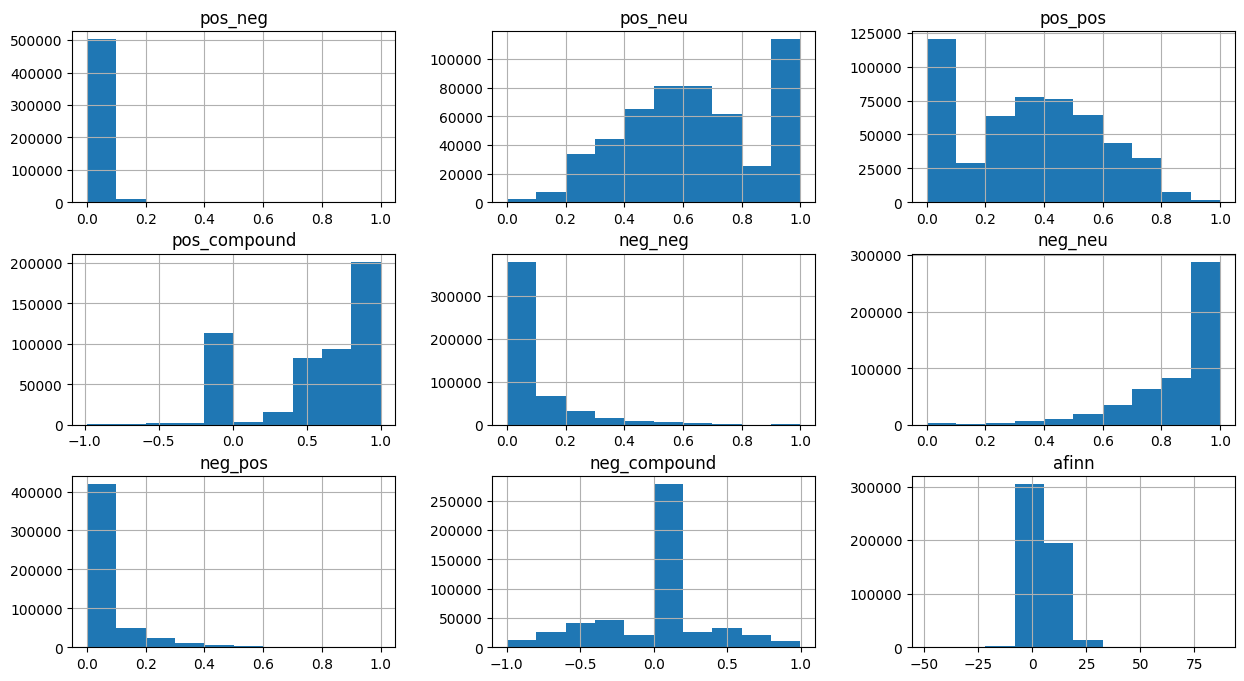

In [63]:
reviews.hist(figsize=(15, 8));

Как видим, признаки расположены ненормально, поэтому используем корреляцию Спирмена, чтобы посмотреть, есть ли среди них мультиколлинеарность.

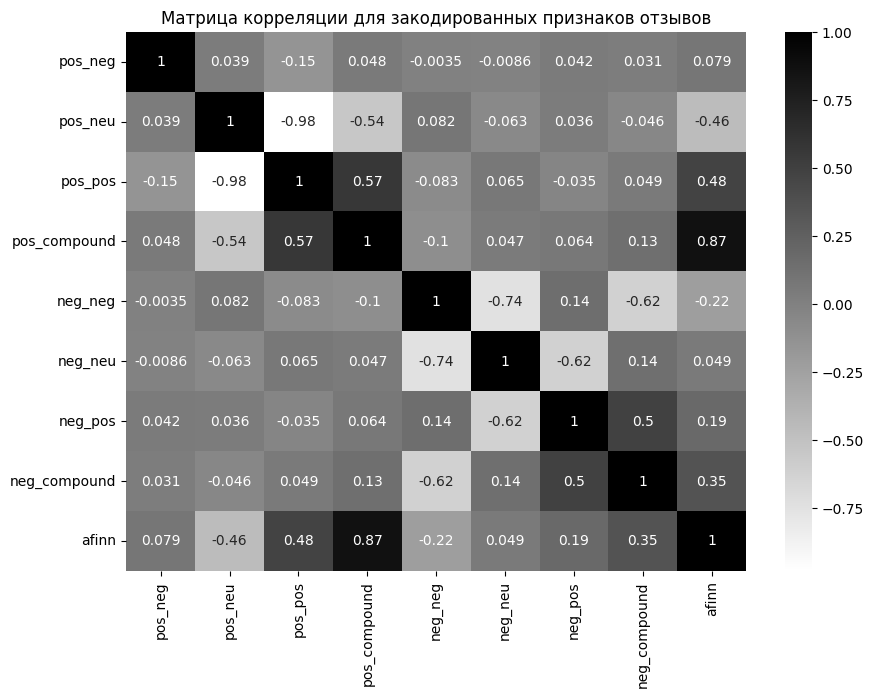

In [64]:
plt.figure(figsize=(10, 7))
corr_heatmap = sns.heatmap(reviews.corr(numeric_only=True, method='spearman'), annot=True, cmap='binary')
corr_heatmap.set_title('Матрица корреляции для закодированных признаков отзывов');

Наблюдается очень сильная корреляция признаков pos_pos и pos_neu, равная $-0.98$.

Ещё наблюдается сильная корреляция между afinn и pos_compound, избавимся от одного из них. Выберу pos_compound, чтобы было больше вариативности из разных библиотек анализа текста.

In [65]:
# Удаляем коррелирующие признаки из списка и добавим новый, afinn
polarity_score_keys.remove('pos_neu')
polarity_score_keys.remove('pos_compound')
polarity_score_keys.append('afinn')
all_reviews = ['positive_review', 'negative_review']
hotels = pd.concat([hotels.drop(columns=all_reviews), reviews[polarity_score_keys]], axis=1)
hotels.head(3)

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,...,is_capital,SWL,review_rate,pos_neg,pos_pos,neg_neg,neg_neu,neg_pos,neg_compound,afinn
0,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,52,16670,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",...,0,230.00,1.188679,0.0,0.329,0.129,0.747,0.125,-0.0554,25.0
1,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,10,5018,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",...,0,250.00,0.090909,0.0,0.000,0.216,0.784,0.000,-0.2960,-1.0
2,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,3,351,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",...,0,233.33,1.500000,0.0,0.740,0.000,1.000,0.000,0.0000,3.0


___

### Анализ категориальных признаков